In [28]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import json

In [3]:
from helpers import *

initial_power = 120 * si.uW 
initial_grad = -2 * si.G/si.cm

trap: PancakeTrap = PancakeTrap(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= initial_grad,
    grad_r=0,
    power_tweezer= initial_power,
    waist_tweezer= 2.2 * si.um,
    a=184.4*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),

    wvl = 1064 * si.nm,
)
axial_width = trap.get_tweezer_rayleigh()
zr = float(trap.subs(trap.get_tweezer_rayleigh()))

x, y, z = trap.x, trap.y, trap.z

print(f"{float(trap.subs(trap.get_omega_ax_tweezer()))}Hz")
print(f"{trap.subs(trap.a *2*trap.power_tweezer/(np.pi*trap.waist_tweezer**2)/ const.k) /si.uK} uK")

aspect_ratio = trap.get_omega_r_tweezer() / trap.get_omega_ax_tweezer()
_aspect_ratio_latex = sp.latex(trap.omega_r_tweezer / trap.omega_ax_tweezer)
display(Math(f"{_aspect_ratio_latex} \\approx {trap.subs(aspect_ratio).evalf():.2f}"))

570.1441372938781Hz
0.654720901556131 uK


<IPython.core.display.Math object>

In [9]:
def sweep_power(trap, gradient,dp,n_levels,left_cutoff,right_cutoff,t_spill=25*si.ms,max_spill_steps=200,n_pot_steps=1000):
    """
    Sweeps over power and gets the power for 0 atom boundary and the precision level
    """
    max_atoms = 10

    x, y, z = trap.x, trap.y, trap.z
    zr = trap.get_tweezer_rayleigh()

    trap[trap.grad_z] = gradient
    initial_power = 4/3/np.sqrt(3)*trap.subs(zr) * np.pi* trap.subs(trap.m * trap.g + trap.mu_b * trap.grad_z) * trap.subs(trap.waist_tweezer**2/trap.a)
    trap[trap.power_tweezer] = initial_power
    powers = np.array([initial_power],dtype=float)
    atom_number = np.array([0.0],dtype=float)

    i = 0
    pbar = tqdm(disable=True)
    while atom_number[i] <max_atoms and i<max_spill_steps:
        #print(i)
        trap[trap.power_tweezer] = initial_power + (i+1)*dp
        powers = np.append(powers, initial_power + (i+1)*dp)

        # Solve the hamiltonian numerically in axial direction
        energies, states, potential, coords = trap.nstationary_solution(
            trap.z, (left_cutoff, right_cutoff), n_pot_steps, k=n_levels
        )

        # Determine the potential and its derivatives
        pot_ax = trap.subs(trap.get_potential())
        pot_diff_ax = sp.diff(pot_ax, trap.z)
        pot_diff2_ax = sp.diff(pot_diff_ax, trap.z)
        pot_diff3_ax = sp.diff(pot_diff2_ax, trap.z)
        pot_diff_ax_numpy = sp.lambdify(trap.z, pot_diff_ax.subs({x: 0, y: 0}))
        pot_diff2_ax_numpy = sp.lambdify(trap.z, pot_diff2_ax.subs({x: 0, y: 0}))
        pot_diff3_ax_numpy = sp.lambdify(trap.z, pot_diff3_ax.subs({x: 0, y: 0}))

        barrier = root_scalar(
            pot_diff_ax_numpy,
            x0=1.5 * float(trap.subs(zr)),
            fprime=pot_diff2_ax_numpy,
            xtol=1e-28,
            fprime2=pot_diff3_ax_numpy,
        ).root
        minimum = root_scalar(
            pot_diff_ax_numpy,
            x0=0,
            fprime=pot_diff2_ax_numpy,
            xtol=1e-28,
            fprime2=pot_diff3_ax_numpy,
        ).root
        # States that are below the potential barrier
        bound_states = energies < potential(barrier)

        # Density of states is larger on the left than on the right
        # Likely that the state in question is a true bound state
        true_bound_states = np.logical_and(
            bound_states,
            np.sum(states[:, coords[z] < barrier] ** 2, axis=1)
            > np.sum(states[:, coords[z] > barrier] ** 2, axis=1),
        )
        
        if t_spill == 0:
            atom_num = np.sum(true_bound_states)
            atom_number = np.append(atom_number,atom_num)
            continue

        transmission_probability = np.full_like(energies, np.nan, dtype=float)
        for j, energy in enumerate(energies):
            if not true_bound_states[j]:
                continue
            intersect_end = root_scalar(
                lambda x: potential(x) - energy,
                bracket=(barrier, 3 * float(trap.subs(zr))),
            ).root
            intersect_start = root_scalar(
                lambda x: potential(x) - energy,
                bracket=(minimum, barrier),
            ).root

            s = quad(
                lambda x: np.sqrt(
                    2
                    * float(trap.subs(trap.m))
                    * np.clip(potential(x) - energy, a_min=0, a_max=None)
                )
                / const.hbar,
                intersect_start,
                intersect_end,
            )
            transmission_probability[j] = sp.exp(-2 * s[0])
        tunneling_rate = (
            transmission_probability * np.abs(energies - potential(minimum)) / const.h
        )

        atom_num = np.sum(np.exp(-t_spill * tunneling_rate[true_bound_states]))
        atom_number = np.append(atom_number,atom_num)
        #print(atom_num)
        i += 1
        pbar.update(1)

    pbar.close()
    if i == max_spill_steps:
        print(f"{max_atoms} atoms not reached")
        return powers,atom_number
        raise Exception(f"{max_atoms} atoms not reached")

    return powers, atom_number

def sweep_gradient(trap, power,dgrad,n_levels,left_cutoff,right_cutoff,t_spill=25*si.ms,max_spill_steps=200,n_pot_steps=1000):
    """
    Sweeps over gradient and gets the gradient for 0 atom boundary and the precision level
    """
    max_atoms = 10

    x, y, z = trap.x, trap.y, trap.z
    zr = trap.get_tweezer_rayleigh()

    trap[trap.power_tweezer] = power
    initial_grad = float(trap.subs(1/trap.mu_b * (3*np.sqrt(3)/4 * power * trap.a/np.pi/trap.waist_tweezer**2/zr - trap.m * trap.g)))
    trap[trap.grad_z] = initial_grad
    gradients = np.array([initial_grad],dtype=float)
    atom_number = np.array([0.0],dtype=float)

    i = 0
    pbar = tqdm(disable=True)
    while atom_number[i] <max_atoms and i<max_spill_steps:
        #print(i)
        trap[trap.grad_z] = initial_grad - (i+1)*dgrad
        gradients = np.append(gradients, initial_grad - (i+1)*dgrad)

        # Solve the hamiltonian numerically in axial direction
        energies, states, potential, coords = trap.nstationary_solution(
            trap.z, (left_cutoff, right_cutoff), n_pot_steps, k=n_levels
        )

        # Determine the potential and its derivatives
        pot_ax = trap.subs(trap.get_potential())
        pot_diff_ax = sp.diff(pot_ax, trap.z)
        pot_diff2_ax = sp.diff(pot_diff_ax, trap.z)
        pot_diff3_ax = sp.diff(pot_diff2_ax, trap.z)
        pot_diff_ax_numpy = sp.lambdify(trap.z, pot_diff_ax.subs({x: 0, y: 0}))
        pot_diff2_ax_numpy = sp.lambdify(trap.z, pot_diff2_ax.subs({x: 0, y: 0}))
        pot_diff3_ax_numpy = sp.lambdify(trap.z, pot_diff3_ax.subs({x: 0, y: 0}))

        barrier = root_scalar(
            pot_diff_ax_numpy,
            x0=1.5 * float(trap.subs(zr)),
            fprime=pot_diff2_ax_numpy,
            xtol=1e-28,
            fprime2=pot_diff3_ax_numpy,
        ).root
        minimum = root_scalar(
            pot_diff_ax_numpy,
            x0=0,
            fprime=pot_diff2_ax_numpy,
            xtol=1e-28,
            fprime2=pot_diff3_ax_numpy,
        ).root
        # States that are below the potential barrier
        bound_states = energies < potential(barrier)

        # Density of states is larger on the left than on the right
        # Likely that the state in question is a true bound state
        true_bound_states = np.logical_and(
            bound_states,
            np.sum(states[:, coords[z] < barrier] ** 2, axis=1)
            > np.sum(states[:, coords[z] > barrier] ** 2, axis=1),
        )
        
        if t_spill == 0:
            atom_num = np.sum(true_bound_states)
            atom_number = np.append(atom_number,atom_num)
            continue

        transmission_probability = np.full_like(energies, np.nan, dtype=float)
        for j, energy in enumerate(energies):
            if not true_bound_states[j]:
                continue
            intersect_end = root_scalar(
                lambda x: potential(x) - energy,
                bracket=(barrier, 3 * float(trap.subs(zr))),
            ).root
            intersect_start = root_scalar(
                lambda x: potential(x) - energy,
                bracket=(minimum, barrier),
            ).root

            s = quad(
                lambda x: np.sqrt(
                    2
                    * float(trap.subs(trap.m))
                    * np.clip(potential(x) - energy, a_min=0, a_max=None)
                )
                / const.hbar,
                intersect_start,
                intersect_end,
            )
            transmission_probability[j] = sp.exp(-2 * s[0])
        tunneling_rate = (
            transmission_probability * np.abs(energies - potential(minimum)) / const.h
        )

        atom_num = np.sum(np.exp(-t_spill * tunneling_rate[true_bound_states]))
        atom_number = np.append(atom_number,atom_num)
        #print(atom_num)
        i += 1
        pbar.update(1)

    pbar.close()
    if i == max_spill_steps:
        print(f"{max_atoms} atoms not reached")
        return gradients,atom_number
        raise Exception(f"{max_atoms} atoms not reached")

    return gradients, atom_number

def calculate_stepsize(powers, atom_number,plot=False):
    max_atoms = 10

    bool_array = np.logical_and(np.abs(atom_number - np.round(atom_number,0)) < 0.1, atom_number > 0.05) #find points where atomnumber is close to integer
    bool_array = np.logical_and(bool_array, atom_number < (max_atoms-0.5))
    if plot:
        plt.plot(powers/si.uW,atom_number)
        plt.plot(powers[bool_array]/si.uW,atom_number[bool_array],"b.")
        plt.xlabel("power [uW]")
        plt.ylabel("atom number")

    diff = np.diff(bool_array.astype(int))  # Convert to int to use np.diff
    start_indices = np.where(diff == 1)[0] + 1  # Indices where blobs start
    end_indices = np.where(diff == -1)[0] + 1  # Indices where blobs end

    # Special case: handle if the array starts or ends with a True
    if bool_array[0]:
        start_indices = np.insert(start_indices, 0, 0)  # Add the start of the array
    if bool_array[-1]:
        end_indices = np.append(end_indices, len(bool_array))  # Add the end of the array

    #step length
    step_len = np.abs(np.mean(np.diff(powers)))

    # Blob lengths
    blob_lengths = float(np.mean((end_indices - start_indices)*step_len))

    # Results
    return blob_lengths

In [4]:
powers, atom_number = sweep_power(trap, -2.5*si.G/si.cm, 0.35*si.uW, 50, -0*zr, 1.1*zr,max_spill_steps=200)

0.933333333333319

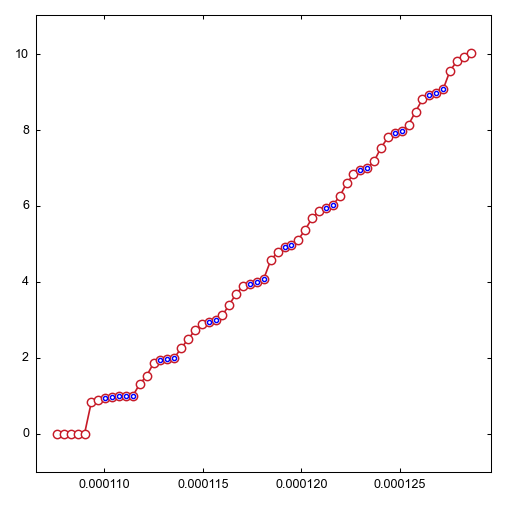

In [ ]:
calculate_stepsize(powers,atom_number,plot=True)/si.uW

In [63]:
powers/si.uW

array([780.040388671187, 780.540388671187, 781.040388671187,
       781.540388671187, 782.040388671187, 782.540388671187,
       783.040388671187, 783.540388671187, 784.040388671187,
       784.540388671187, 785.040388671187, 785.540388671187,
       786.040388671187, 786.540388671187, 787.040388671187,
       787.540388671187, 788.040388671187, 788.540388671187,
       789.040388671187, 789.540388671187, 790.040388671187,
       790.540388671187, 791.040388671187, 791.540388671187,
       792.040388671187, 792.540388671187, 793.040388671187,
       793.540388671187, 794.040388671187, 794.540388671187,
       795.040388671187, 795.540388671187, 796.040388671187,
       796.540388671187, 797.040388671187, 797.540388671187,
       798.040388671187, 798.540388671187, 799.040388671187,
       799.540388671187, 800.040388671187, 800.540388671187,
       801.040388671187, 801.540388671187, 802.040388671187,
       802.540388671187, 803.040388671187, 803.540388671187,
       804.040388671187,

In [59]:
atom_number

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.62227389, 0.62205177, 0.66703707,
       0.7316383 , 0.79751587, 0.85413323, 0.89628386, 0.91264018,
       0.9667693 , 0.9781576 , 0.98652226, 0.99192706, 0.99526371,
       1.23955124, 1.26957128, 1.3621218 , 1.49125772, 1.62627378,
       1.7437065 , 1.83334773, 1.89530142, 1.92914666, 1.96545884,
       1.97988899, 1.98861675, 2.02596721, 2.08254169, 2.46069322,
       2.55763511, 2.68842951, 2.79861223, 2.87697602, 2.92775398,
       2.96221612, 2.98677672, 3.02304278, 3.1026014 , 3.24429251,
       3.4263682 , 3.60388008, 3.74453774, 3.87117947, 3.9158921 ,
       3.9522758 , 3.97492919, 3.99886771, 4.0470266 , 4.34229862,
       4.48745856, 4.65252645, 4.78399447, 4.87330454, 4.92858111,
       4.96531353, 4.99767932, 5.06344421, 5.19901076, 5.39127931,
       5.58628031, 5.74222231, 5.84882082, 5.91347751, 5.95503228,
       5.98248307, 6.0364209 , 6.16347741, 6.35114515, 6.62254

In [170]:
gradients, atom_number = sweep_gradient(trap, 1900*si.uW, 0.0018*si.G/si.cm, 50, -0*zr, 1.1*zr,max_spill_steps=200)

10 atoms not reached


0.017099999999999994

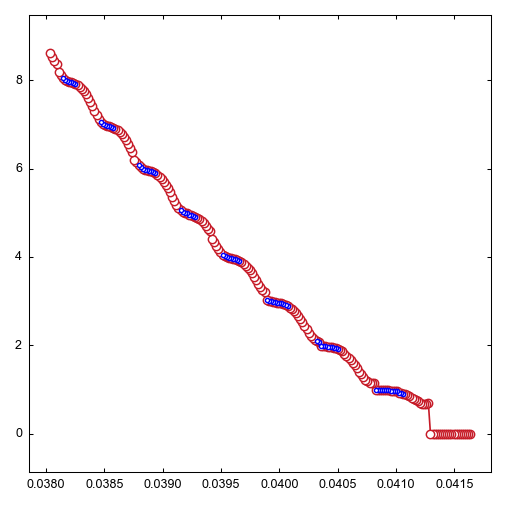

In [171]:
calculate_stepsize(gradients,atom_number,plot=True)/si.G*si.cm

In [101]:
gradients /si.G*si.cm

array([-1.50154822e-04, -5.15015482e-03, -1.01501548e-02, -1.51501548e-02,
       -2.01501548e-02, -2.51501548e-02, -3.01501548e-02, -3.51501548e-02,
       -4.01501548e-02, -4.51501548e-02, -5.01501548e-02, -5.51501548e-02,
       -6.01501548e-02, -6.51501548e-02, -7.01501548e-02, -7.51501548e-02,
       -8.01501548e-02, -8.51501548e-02, -9.01501548e-02, -9.51501548e-02,
       -1.00150155e-01, -1.05150155e-01, -1.10150155e-01, -1.15150155e-01,
       -1.20150155e-01, -1.25150155e-01, -1.30150155e-01, -1.35150155e-01,
       -1.40150155e-01, -1.45150155e-01, -1.50150155e-01, -1.55150155e-01,
       -1.60150155e-01, -1.65150155e-01, -1.70150155e-01, -1.75150155e-01,
       -1.80150155e-01, -1.85150155e-01, -1.90150155e-01, -1.95150155e-01,
       -2.00150155e-01, -2.05150155e-01, -2.10150155e-01, -2.15150155e-01,
       -2.20150155e-01, -2.25150155e-01, -2.30150155e-01, -2.35150155e-01,
       -2.40150155e-01])

In [75]:
atom_number

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

  0%|          | 0/2 [00:00<?, ?it/s]

0


 50%|█████     | 1/2 [01:07<01:07, 67.86s/it]

For -2.5G/cm (107.58993700664912uW): dB'=0.003200000000000005G/cm (rel: -0.1280000000000002%), dP = 0.933333333333319uW (rel: 0.8674912908217788%)
1


100%|██████████| 2/2 [07:05<00:00, 212.95s/it]

10 atoms not reached
For 4.0G/cm (1855.9611113344472uW): dB'=0.0166G/cm (rel: 0.4150000000000001%), dP = 4.588888888890075uW (rel: 0.247251349226312%)


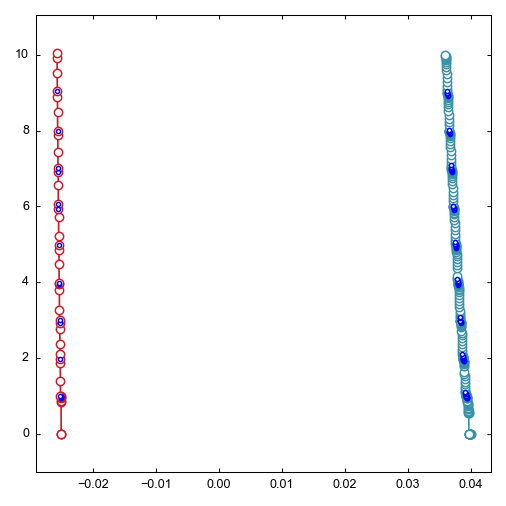

In [27]:
max_spill_steps = 200

many_grad = np.linspace(-2.5,4,2)*si.G/si.cm
many_power = np.zeros_like(many_grad)
step_grad = np.zeros_like(many_grad)
step_power = np.zeros_like(many_grad)

all_gradients = np.zeros((len(many_grad),max_spill_steps+1))
all_powers = np.zeros((len(many_grad),max_spill_steps+1))

all_atoms_grad = np.zeros((len(many_grad),max_spill_steps+1))
all_atoms_power = np.zeros((len(many_grad),max_spill_steps+1))

for i, initial_grad in tqdm(enumerate(many_grad),total=len(many_grad)):
    print(i)
    many_power[i] = 4/3/np.sqrt(3)*zr * np.pi* trap.subs(trap.m * trap.g + trap.mu_b * initial_grad) * trap.subs(trap.waist_tweezer**2/trap.a)

    gradients, atom_number = sweep_gradient(trap, many_power[i], 0.0018*si.G/si.cm, 50, -0*zr, 1.1*zr,max_spill_steps=max_spill_steps)
    step_grad[i] = calculate_stepsize(gradients,atom_number,plot=True)
    all_gradients[i,:len(gradients)] = gradients
    all_atoms_grad[i,:len(atom_number)] = atom_number

    powers, atom_number = sweep_power(trap, initial_grad, 0.35*si.uW, 50, -0*zr, 1.1*zr,max_spill_steps=max_spill_steps)
    step_power[i] = calculate_stepsize(powers,atom_number)
    all_powers[i,:len(powers)] = powers
    all_atoms_power[i,:len(atom_number)] = atom_number

    print(f"For {initial_grad/si.G*si.cm}G/cm ({many_power[i]/si.uW}uW): dB'={step_grad[i]/si.G*si.cm}G/cm (rel: {step_grad[i]/initial_grad*100}%), dP = {step_power[i]/si.uW}uW (rel: {step_power[i]/many_power[i]*100}%)")

np.savez('sweeps_1064.npz', all_gradients=all_gradients, all_atoms_grad=all_atoms_grad, all_powers=all_powers, all_atoms_power=all_atoms_power)

  0%|          | 0/15 [00:00<?, ?it/s]

0


  7%|▋         | 1/15 [01:06<15:34, 66.73s/it]

For -2.5G/cm (107.58993700664912uW): dB'=0.003200000000000005G/cm (rel: 0.1280000000000002%), dP = 0.933333333333319uW (rel: 0.8674912908217788%)
1


 13%|█▎        | 2/15 [02:54<19:38, 90.67s/it]

For -2.035714285714285G/cm (232.4735923157776uW): dB'=0.005199999999999998G/cm (rel: 0.255438596491228%), dP = 1.4388888888889206uW (rel: 0.6189472423751355%)
2


 20%|██        | 3/15 [05:16<22:51, 114.31s/it]

For -1.5714285714285714G/cm (357.357247624906uW): dB'=0.0068000000000000066G/cm (rel: 0.4327272727272732%), dP = 1.7499999999999039uW (rel: 0.48970603272520213%)
3


 27%|██▋       | 4/15 [08:11<25:21, 138.33s/it]

For -1.1071428571428572G/cm (482.24090293403447uW): dB'=0.007600000000000004G/cm (rel: 0.6864516129032262%), dP = 2.1777777777776604uW (rel: 0.45159540896006445%)
4


 33%|███▎      | 5/15 [11:26<26:26, 158.65s/it]

For -0.6428571428571428G/cm (607.1245582431628uW): dB'=0.008800000000000004G/cm (rel: 1.3688888888888895%), dP = 2.372222222222103uW (rel: 0.3907307306241418%)
5


 40%|████      | 6/15 [15:05<26:52, 179.13s/it]

For -0.17857142857142835G/cm (732.0082135522914uW): dB'=0.009800000000000001G/cm (rel: 5.4880000000000075%), dP = 2.7222222222220767uW (rel: 0.3718841089243616%)
6


 47%|████▋     | 7/15 [19:10<26:45, 200.73s/it]

10 atoms not reached
For 0.2857142857142856G/cm (856.8918688614198uW): dB'=0.010799999999999999G/cm (rel: 3.7800000000000016%), dP = 2.9555555555553896uW (rel: 0.34491581294644946%)
7


 53%|█████▎    | 8/15 [23:01<24:32, 210.35s/it]

10 atoms not reached
For 0.75G/cm (981.7755241705482uW): dB'=0.011399999999999997G/cm (rel: 1.5199999999999996%), dP = 3.344444444444331uW (rel: 0.34065266062421756%)
8


 60%|██████    | 9/15 [26:57<21:49, 218.31s/it]

10 atoms not reached
For 1.2142857142857144G/cm (1106.6591794796764uW): dB'=0.012399999999999998G/cm (rel: 1.021176470588235%), dP = 3.5875000000009134uW (rel: 0.3241738799553143%)
9


 67%|██████▋   | 10/15 [30:49<18:32, 222.49s/it]

10 atoms not reached
For 1.6785714285714288G/cm (1231.5428347888048uW): dB'=0.013200000000000002G/cm (rel: 0.7863829787234041%), dP = 4.000000000001052uW (rel: 0.3247958485087532%)
10


 73%|███████▎  | 11/15 [34:45<15:06, 226.65s/it]

10 atoms not reached
For 2.1428571428571432G/cm (1356.4264900979335uW): dB'=0.0146G/cm (rel: 0.6813333333333332%), dP = 4.200000000001076uW (rel: 0.30963712598224447%)
11


 80%|████████  | 12/15 [38:39<11:26, 228.84s/it]

10 atoms not reached
For 2.6071428571428577G/cm (1481.310145407062uW): dB'=0.014000000000000002G/cm (rel: 0.5369863013698629%), dP = 4.491666666667825uW (rel: 0.30322256825112887%)
12
10 atoms not reached


 87%|████████▋ | 13/15 [42:27<07:37, 228.56s/it]

10 atoms not reached
For 3.071428571428571G/cm (1606.1938007161903uW): dB'=0.015999999999999993G/cm (rel: 0.5209302325581393%), dP = 4.666666666667878uW (rel: 0.29054194236007175%)
13
10 atoms not reached


 93%|█████████▎| 14/15 [46:04<03:45, 225.14s/it]

10 atoms not reached
For 3.5357142857142856G/cm (1731.077456025319uW): dB'=0.016799999999999995G/cm (rel: 0.47515151515151505%), dP = 5.600000000001483uW (rel: 0.32349794519648445%)
14
10 atoms not reached


100%|██████████| 15/15 [49:37<00:00, 198.51s/it]

10 atoms not reached
For 4.0G/cm (1855.9611113344472uW): dB'=0.017324999999999997G/cm (rel: 0.4331249999999999%), dP = 5.250000000001361uW (rel: 0.2828723063182385%)


TypeError: Object of type ndarray is not JSON serializable

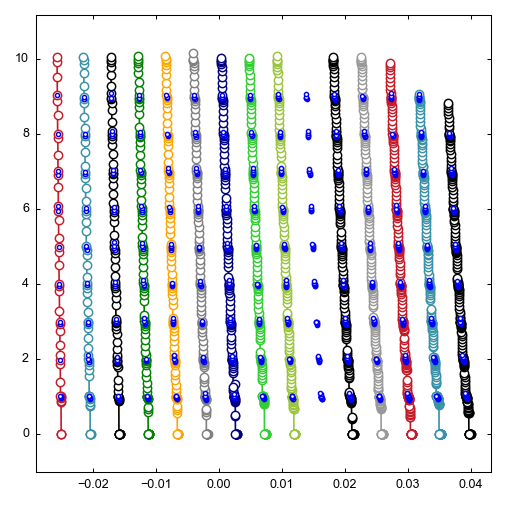

In [31]:
max_spill_steps = 200

many_grad = np.linspace(-2.5,4,15)*si.G/si.cm
many_power = np.zeros_like(many_grad)
step_grad = np.zeros_like(many_grad)
step_power = np.zeros_like(many_grad)

data = {"gradient":np.zeros_like(many_grad),
       "power":np.zeros_like(many_grad),
       "gradient_step":np.zeros_like(many_grad),
       "power_step":np.zeros_like(many_grad),
       "gradient_rel":np.zeros_like(many_grad),
       "power_rel":np.zeros_like(many_grad)
       }

for i, initial_grad in tqdm(enumerate(many_grad),total=len(many_grad)):
    #print(i)
    many_power[i] = 4/3/np.sqrt(3)*zr * np.pi* trap.subs(trap.m * trap.g + trap.mu_b * initial_grad) * trap.subs(trap.waist_tweezer**2/trap.a)

    gradients, atom_number = sweep_gradient(trap, many_power[i], 0.0018*si.G/si.cm, 50, -0*zr, 1.1*zr,max_spill_steps=max_spill_steps)
    step_grad[i] = calculate_stepsize(gradients,atom_number,plot=True)

    powers, atom_number = sweep_power(trap, initial_grad, 0.35*si.uW, 50, -0*zr, 1.1*zr,max_spill_steps=max_spill_steps)
    step_power[i] = calculate_stepsize(powers,atom_number)

    print(f"For {initial_grad/si.G*si.cm}G/cm ({many_power[i]/si.uW}uW): dB'={step_grad[i]/si.G*si.cm}G/cm (rel: {step_grad[i]/np.abs(initial_grad)*100}%), dP = {step_power[i]/si.uW}uW (rel: {step_power[i]/many_power[i]*100}%)")

    data["gradient"][i] = initial_grad
    data["power"][i] = many_power[i]
    data["gradient_step"][i] = step_grad[i]
    data["gradient_rel"][i] = step_grad[i]/np.abs(initial_grad)
    data["power_step"][i] = step_power[i]
    data["power_rel"][i] = step_power[i]/many_power[i]


# Save dictionary to numpy file
np.savez("sweeps_1064.npz",gradient=data["gradient"], power = data["power"],gradient_step = data["gradient_step"],gradient_rel = data["gradient_rel"],power_step = data["power_step"],power_rel = data["power_rel"])

# Repeat with 532nm and 1.1um

In [5]:
from helpers import *

initial_power = 350 * si.uW 
initial_grad = 6 * si.G/si.cm

trap: PancakeTrap = PancakeTrap(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= initial_grad,
    grad_r=0,
    power_tweezer= initial_power,
    waist_tweezer= 1.1 * si.um,
    a=180*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),

    wvl = 532 * si.nm,
)
axial_width = trap.get_tweezer_rayleigh()
zr = float(trap.subs(trap.get_tweezer_rayleigh()))

x, y, z = trap.x, trap.y, trap.z

print(f"{float(trap.subs(trap.get_omega_ax_tweezer()))}Hz")
print(f"{trap.subs(trap.a *2*trap.power_tweezer/(np.pi*trap.waist_tweezer**2)/ const.k) /si.uK} uK")

aspect_ratio = trap.get_omega_r_tweezer() / trap.get_omega_ax_tweezer()
_aspect_ratio_latex = sp.latex(trap.omega_r_tweezer / trap.omega_ax_tweezer)
display(Math(f"{_aspect_ratio_latex} \\approx {trap.subs(aspect_ratio).evalf():.2f}"))

3848.077831882Hz
7.45614909581278 uK


<IPython.core.display.Math object>

[3.59572446e+36 4.01587682e+31 2.01795709e+27 2.19743861e+23
 4.21548413e+19 1.29709211e+16 6.09560909e+12 4.26807206e+09
 4.41932281e+06 6.83076213e+03 1.62931178e+01 6.59092263e-02
 6.67030849e-04] s
-3.065859783967385e-29


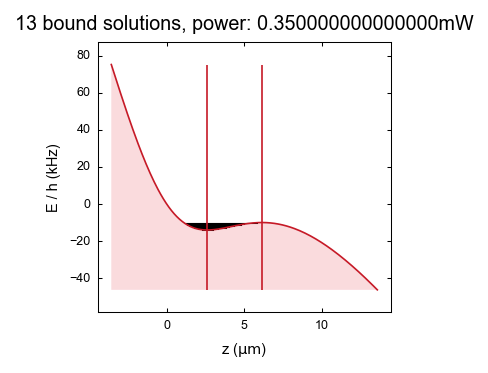

In [6]:
plot_solutions(trap,150,-0.5*zr,1.9*zr,n_pot_steps=200,display_plot=-2,state_mult=1e3)

0.8333333333333517

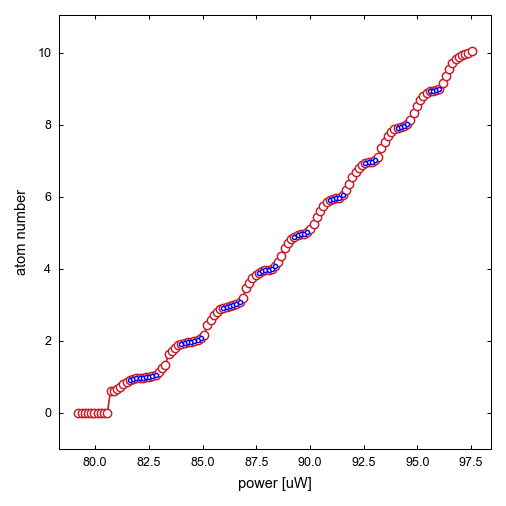

In [10]:
powers, atom_number = sweep_power(trap, -0.6*si.G/si.cm, 0.15*si.uW, 100, -0.5*zr, 1.9*zr,max_spill_steps=200)
calculate_stepsize(powers,atom_number,plot=True)/si.uW

In [19]:
4/3/np.sqrt(3)*zr * np.pi* trap.subs(trap.m * trap.g + trap.mu_b * 6*si.G/si.cm) * trap.subs(trap.waist_tweezer**2/trap.a)

0.000306554944138628

0.02088888888888889

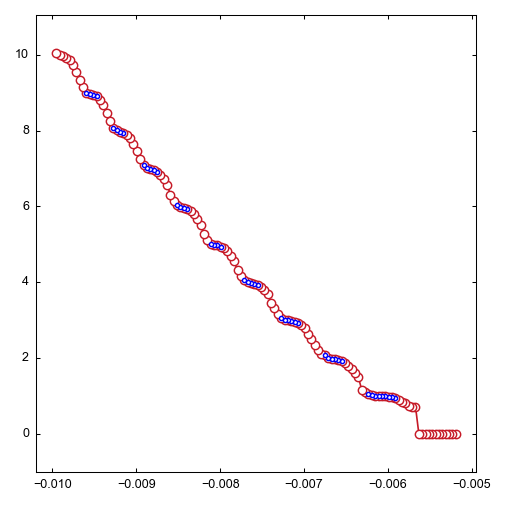

In [12]:
gradients, atom_number = sweep_gradient(trap, 82*si.uW, 0.004*si.G/si.cm, 50, -0.5*zr, 1.9*zr,max_spill_steps=200)
calculate_stepsize(gradients,atom_number,plot=True)/si.G*si.cm

  0%|          | 0/25 [00:00<?, ?it/s]

0


  4%|▍         | 1/25 [01:18<31:24, 78.54s/it]

For -2.5G/cm (13.777489155573681uW): dB'=0.007111111111111115G/cm (rel: 0.2844444444444446%), dP = 0.35000000000000064uW (rel: 2.5403757974173993%)
1


  8%|▊         | 2/25 [03:37<43:44, 114.11s/it]

For -1.9791666666666665G/cm (31.717284191300074uW): dB'=0.012000000000000004G/cm (rel: 0.6063157894736845%), dP = 0.5166666666666667uW (rel: 1.628975115115267%)
2


 12%|█▏        | 3/25 [06:38<53:03, 144.69s/it]

For -1.4583333333333335G/cm (49.65707922702644uW): dB'=0.015555555555555559G/cm (rel: 1.0666666666666669%), dP = 0.6333333333333333uW (rel: 1.2754139856631643%)
3


 16%|█▌        | 4/25 [10:16<1:00:44, 173.54s/it]

For -0.9374999999999999G/cm (67.59687426275283uW): dB'=0.01955555555555556G/cm (rel: 2.0859259259259266%), dP = 0.7666666666666778uW (rel: 1.1341747307524925%)
4


 20%|██        | 5/25 [14:23<1:06:37, 199.89s/it]

For -0.4166666666666665G/cm (85.53666929847923uW): dB'=0.02177777777777778G/cm (rel: 5.22666666666667%), dP = 0.8833333333333541uW (rel: 1.0326954984077912%)
5


 24%|██▍       | 6/25 [18:57<1:11:22, 225.37s/it]

For 0.10416666666666696G/cm (103.4764643342056uW): dB'=0.026222222222222223G/cm (rel: 25.173333333333257%), dP = 1.03333333333336uW (rel: 0.9986167772373113%)
6


 28%|██▊       | 7/25 [23:59<1:15:08, 250.46s/it]

For 0.625G/cm (121.41625936993198uW): dB'=0.027111111111111114G/cm (rel: 4.337777777777778%), dP = 1.0333333333333612uW (rel: 0.8510666847221783%)
7


 32%|███▏      | 8/25 [29:26<1:17:49, 274.68s/it]

For 1.1458333333333337G/cm (139.35605440565837uW): dB'=0.028000000000000004G/cm (rel: 2.4436363636363634%), dP = 1.1500000000000274uW (rel: 0.8252242824358645%)
8


 36%|███▌      | 9/25 [35:12<1:19:09, 296.87s/it]

For 1.666666666666667G/cm (157.29584944138475uW): dB'=0.032444444444444456G/cm (rel: 1.946666666666667%), dP = 1.266666666666699uW (rel: 0.8052765989472049%)
9


 40%|████      | 10/25 [41:27<1:20:17, 321.13s/it]

For 2.1874999999999996G/cm (175.23564447711112uW): dB'=0.035111111111111114G/cm (rel: 1.6050793650793653%), dP = 1.2666666666666986uW (rel: 0.7228361960526516%)
10


 44%|████▍     | 11/25 [48:19<1:21:23, 348.81s/it]

For 2.708333333333334G/cm (193.17543951283756uW): dB'=0.037777777777777785G/cm (rel: 1.3948717948717946%), dP = 1.383333333333366uW (rel: 0.716102076341561%)
11


 48%|████▊     | 12/25 [55:52<1:22:29, 380.71s/it]

For 3.229166666666667G/cm (211.1152345485639uW): dB'=0.03911111111111109G/cm (rel: 1.211182795698924%), dP = 1.48333333333337uW (rel: 0.7026178553647445%)
12


 52%|█████▏    | 13/25 [1:04:07<1:23:01, 415.11s/it]

For 3.7499999999999996G/cm (229.05502958429028uW): dB'=0.04044444444444444G/cm (rel: 1.0785185185185187%), dP = 1.5000000000000382uW (rel: 0.6548644676008091%)
13


 56%|█████▌    | 14/25 [1:12:46<1:21:51, 446.47s/it]

For 4.270833333333334G/cm (246.99482462001671uW): dB'=0.04133333333333335G/cm (rel: 0.9678048780487806%), dP = 1.533333333333349uW (rel: 0.6207957335512067%)
14


 60%|██████    | 15/25 [1:21:46<1:19:07, 474.73s/it]

For 4.791666666666667G/cm (264.93461965574306uW): dB'=0.043555555555555556G/cm (rel: 0.9089855072463768%), dP = 1.6833333333331981uW (rel: 0.635376884878438%)
15


 64%|██████▍   | 16/25 [1:31:14<1:15:24, 502.76s/it]

For 5.312500000000001G/cm (282.87441469146944uW): dB'=0.04533333333333333G/cm (rel: 0.8533333333333332%), dP = 1.6999999999997324uW (rel: 0.6009734043476216%)
16


 68%|██████▊   | 17/25 [1:41:00<1:10:22, 527.80s/it]

For 5.833333333333334G/cm (300.8142097271959uW): dB'=0.042400000000000014G/cm (rel: 0.7268571428571432%), dP = 1.7333333333330614uW (rel: 0.5762139145304993%)
17


 72%|███████▏  | 18/25 [1:51:04<1:04:14, 550.69s/it]

For 6.354166666666668G/cm (318.7540047629222uW): dB'=0.050222222222222224G/cm (rel: 0.7903825136612022%), dP = 1.849999999999714uW (rel: 0.5803848649292039%)
18


 76%|███████▌  | 19/25 [2:01:43<57:44, 577.47s/it]  

For 6.875G/cm (336.6937997986486uW): dB'=0.05066666666666667G/cm (rel: 0.736969696969697%), dP = 1.899999999999708uW (rel: 0.5643109558702761%)
19


 80%|████████  | 20/25 [2:12:37<50:02, 600.44s/it]

For 7.395833333333333G/cm (354.633594834375uW): dB'=0.05200000000000001G/cm (rel: 0.703098591549296%), dP = 1.9999999999996887uW (rel: 0.5639623625995589%)
20


 84%|████████▍ | 21/25 [2:23:45<41:21, 620.48s/it]

For 7.916666666666669G/cm (372.57338987010144uW): dB'=0.05244444444444445G/cm (rel: 0.6624561403508772%), dP = 1.9999999999996845uW (rel: 0.5368069900797233%)
21


 88%|████████▊ | 22/25 [2:35:07<31:57, 639.12s/it]

For 8.437499999999998G/cm (390.51318490582776uW): dB'=0.056000000000000015G/cm (rel: 0.6637037037037039%), dP = 1.8899999999997041uW (rel: 0.4839785372305618%)
22


 92%|█████████▏| 23/25 [2:46:50<21:56, 658.16s/it]

For 8.958333333333336G/cm (408.45297994155413uW): dB'=0.0568888888888889G/cm (rel: 0.6350387596899226%), dP = 2.099999999999662uW (rel: 0.5141350664892083%)
23


 96%|█████████▌| 24/25 [2:58:49<11:16, 676.33s/it]

For 9.479166666666668G/cm (426.39277497728057uW): dB'=0.060000000000000026G/cm (rel: 0.6329670329670332%), dP = 2.1166666666663376uW (rel: 0.4964124138311489%)
24


100%|██████████| 25/25 [3:10:53<00:00, 458.13s/it]

For 10.0G/cm (444.3325700130069uW): dB'=0.05955555555555558G/cm (rel: 0.5955555555555557%), dP = 2.199999999999657uW (rel: 0.4951246315198673%)


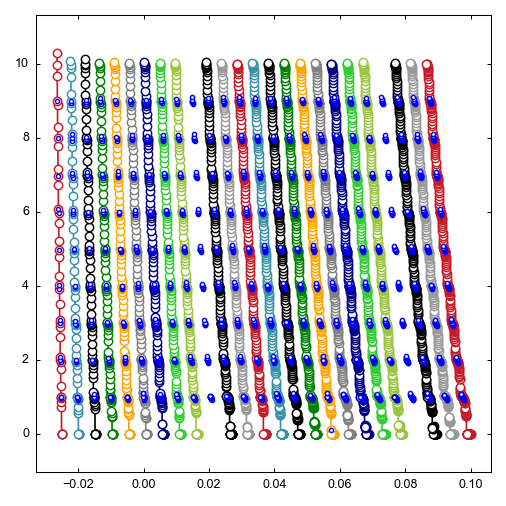

In [32]:
max_spill_steps = 500

many_grad = np.linspace(-2.5,10,25)*si.G/si.cm
many_power = np.zeros_like(many_grad)
step_grad = np.zeros_like(many_grad)
step_power = np.zeros_like(many_grad)

data = {"gradient":np.zeros_like(many_grad),
       "power":np.zeros_like(many_grad),
       "gradient_step":np.zeros_like(many_grad),
       "power_step":np.zeros_like(many_grad),
       "gradient_rel":np.zeros_like(many_grad),
       "power_rel":np.zeros_like(many_grad)
       }

for i, initial_grad in tqdm(enumerate(many_grad),total=len(many_grad)):
    #print(i)
    many_power[i] = 4/3/np.sqrt(3)*zr * np.pi* trap.subs(trap.m * trap.g + trap.mu_b * initial_grad) * trap.subs(trap.waist_tweezer**2/trap.a)

    gradients, atom_number = sweep_gradient(trap, many_power[i], 0.004*si.G/si.cm, 250, -0.5*zr, 1.9*zr,max_spill_steps=max_spill_steps)
    step_grad[i] = calculate_stepsize(gradients,atom_number,plot=True)

    powers, atom_number = sweep_power(trap, initial_grad, 0.15*si.uW, 250, -0.5*zr, 1.9*zr,max_spill_steps=max_spill_steps)
    step_power[i] = calculate_stepsize(powers,atom_number)

    print(f"For {initial_grad/si.G*si.cm}G/cm ({many_power[i]/si.uW}uW): dB'={step_grad[i]/si.G*si.cm}G/cm (rel: {step_grad[i]/np.abs(initial_grad)*100}%), dP = {step_power[i]/si.uW}uW (rel: {step_power[i]/many_power[i]*100}%)")

    data["gradient"][i] = initial_grad
    data["power"][i] = many_power[i]
    data["gradient_step"][i] = step_grad[i]
    data["gradient_rel"][i] = step_grad[i]/np.abs(initial_grad)
    data["power_step"][i] = step_power[i]
    data["power_rel"][i] = step_power[i]/many_power[i]


# Save dictionary to numpy file
np.savez("sweeps_532.npz",gradient=data["gradient"], power = data["power"],gradient_step = data["gradient_step"],gradient_rel = data["gradient_rel"],power_step = data["power_step"],power_rel = data["power_rel"])